In [25]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [59]:
cash = 200000

In [60]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-29_09-32_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [61]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [62]:
#df = df.loc['20190101':'20190701']

In [63]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [64]:
allocs

ES           0.25
YM   JUN     0.25
NQ           0.25
GC           0.25
total        1.00
dtype: float64

In [65]:
df.groupby('contract').realizedPNL.sum()

contract
ES           277022.1
GC            34593.6
NQ           420767.2
YM   JUN     302974.6
Name: realizedPNL, dtype: float64

In [66]:
df.realizedPNL.sum()

1035357.5

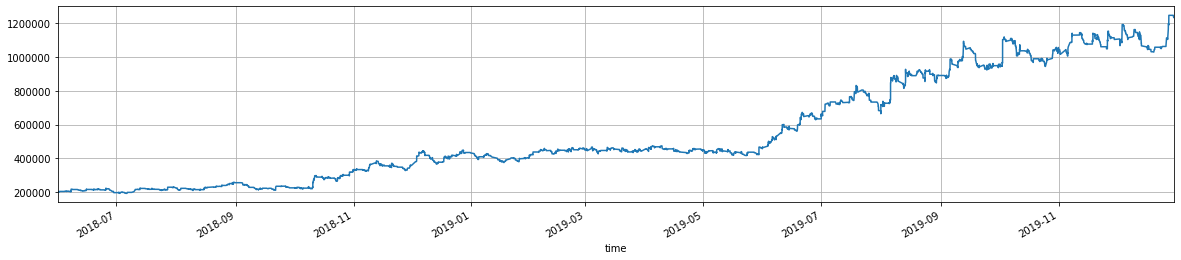

In [67]:
df.cash.plot(figsize=(20,4), grid=True);

In [68]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [69]:
# monthly average number of transactions
by_contract.resample('B').count().resample('M').mean()

contract,ES,GC,NQ,YM JUN,total
time,,,,,
2018-06-30,0.666667,2.666667,4.380952,1.428571,9.142857
2018-07-31,0.590909,2.818182,2.727273,0.818182,6.954545
2018-08-31,0.478261,3.173913,3.130435,1.130435,7.913043
2018-09-30,0.700000,3.000000,4.000000,1.100000,8.750000
2018-10-31,1.565217,2.826087,7.043478,2.521739,13.782609
2018-11-30,0.954545,2.181818,6.136364,1.409091,10.681818
2018-12-31,1.571429,2.285714,6.714286,2.476190,12.952381
2019-01-31,0.826087,2.000000,4.521739,1.521739,8.826087
2019-02-28,0.550000,1.850000,3.600000,1.300000,7.250000


In [70]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES            344
 GC           1208
 NQ           1892
 YM   JUN      612
 Name: action, dtype: int64, 4056)

In [71]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES           0.834951
 GC           2.932039
 NQ           4.592233
 YM   JUN     1.485437
 Name: action, dtype: float64, 9.844660194174757)

In [72]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES            8765.4
GC           42156.4
NQ           47497.8
YM   JUN     16115.4
Name: commission, dtype: float64

In [73]:
df.commission.sum()

114535.00000000001

In [74]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.36,57.27,7129.03,-3965.36,1.80,28.62,604.0
NQ,0.41,444.79,5267.88,-2865.18,1.84,469.37,946.0
YM JUN,0.41,990.11,9364.11,-4715.25,1.99,1057.29,306.0
ES,0.45,1610.59,11388.42,-6314.59,1.80,1651.76,172.0
total,0.40,510.53,6990.62,-3754.78,1.86,543.38,2028.0


In [75]:
by_contract

contract,ES,GC,NQ,YM JUN,total
time,,,,,
2018-06-01 03:18:00,NaN,0.00,NaN,NaN,0.00
2018-06-01 14:38:30,NaN,3150.96,NaN,NaN,3150.96
2018-06-01 15:35:30,NaN,NaN,0.0,NaN,0.00
2018-06-01 16:16:30,NaN,NaN,-696.0,NaN,-696.00
2018-06-01 16:22:00,NaN,NaN,0.0,NaN,0.00
...,...,...,...,...,...
2019-12-27 21:50:30,57707.5,NaN,NaN,NaN,57707.50
2019-12-30 04:23:00,NaN,0.00,NaN,NaN,0.00
2019-12-30 10:48:30,NaN,-13499.08,NaN,NaN,-13499.08


In [96]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM JUN,total
time,,,,,
2018-06-01,0.0,12603.84,4932.0,0.0,4383.96
2018-06-04,0.0,0.00,2432.0,0.0,608.00
2018-06-05,0.0,-7432.32,6448.0,6216.0,1307.92
2018-06-06,0.0,-6295.52,-3784.0,0.0,-2519.88
2018-06-07,28416.0,-17631.04,7516.0,37459.2,13940.04
...,...,...,...,...,...
2019-12-24,0.0,52161.12,0.0,0.0,13040.28
2019-12-25,0.0,0.00,0.0,0.0,0.00
2019-12-26,0.0,202900.48,0.0,0.0,50725.12


In [108]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM JUN,total
time,,,,,
2018-06-01,0.000000,0.015755,0.006165,0.000000,0.021920
2018-06-04,0.000000,0.000000,0.002975,0.000000,0.002975
2018-06-05,0.000000,-0.009064,0.007864,0.007581,0.006380
2018-06-06,0.000000,-0.007629,-0.004586,0.000000,-0.012215
2018-06-07,0.034861,-0.021630,0.009221,0.045955,0.068407
...,...,...,...,...,...
2019-12-24,0.000000,0.012415,0.000000,0.000000,0.012415
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.047701,0.000000,0.000000,0.047701


In [109]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

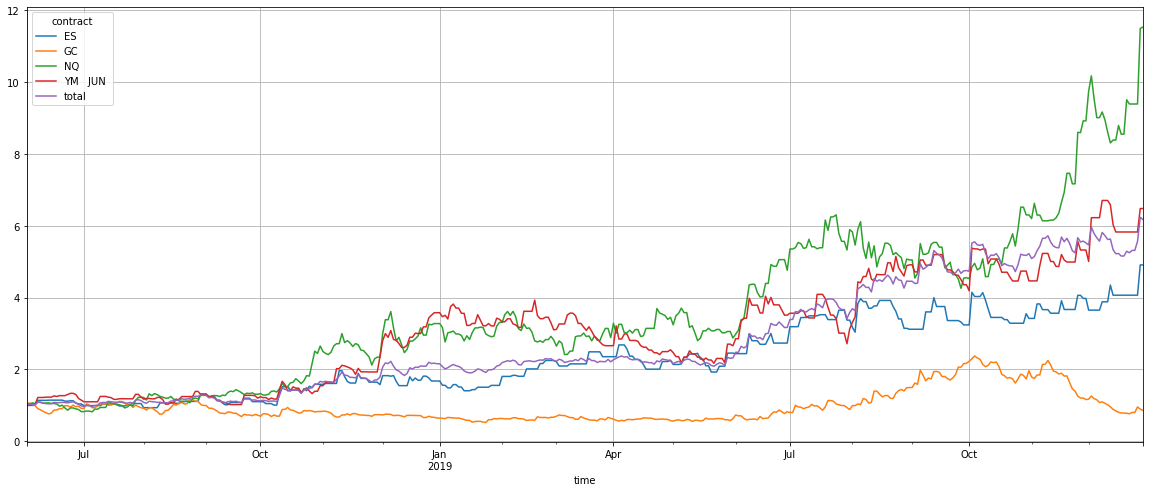

In [110]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [111]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM JUN,total
contract,,,,,
ES,1.000000,-0.061806,0.208012,0.407744,0.619940
GC,-0.061806,1.000000,0.050178,0.084937,0.464158
NQ,0.208012,0.050178,1.000000,0.250474,0.622635
YM JUN,0.407744,0.084937,0.250474,1.000000,0.715771
total,0.619940,0.464158,0.622635,0.715771,1.000000


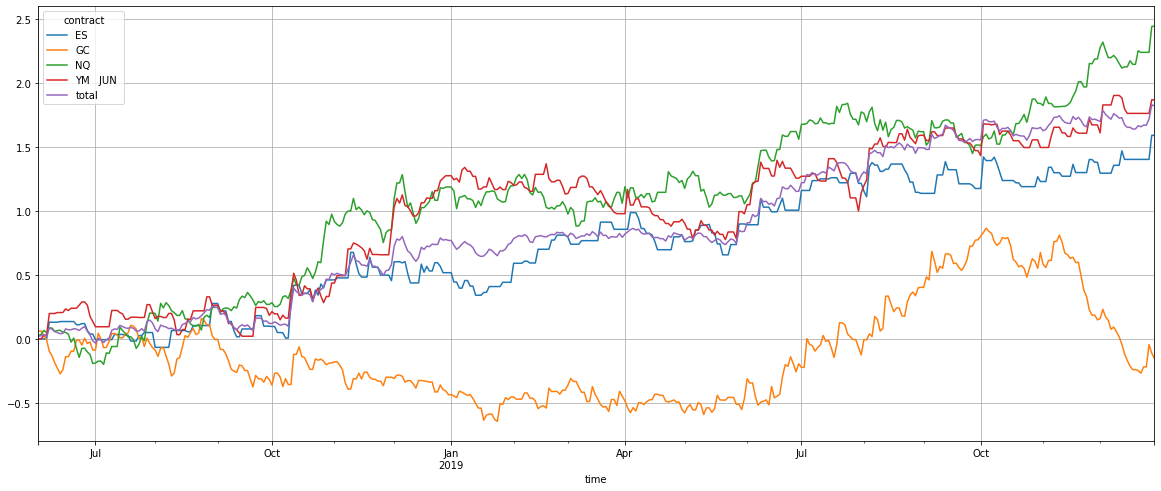

In [112]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

In [113]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM JUN,total
Annual return,1.647261,-0.090164,3.463094,2.137216,2.045582
Cumulative returns,3.911783,-0.143143,10.537278,5.483519,5.176788
Annual volatility,0.845428,0.929072,0.890686,0.908267,0.544652
Sharpe ratio,1.544660,0.338534,2.113591,1.683414,2.309711
Calmar ratio,5.792527,-0.132937,10.420088,4.776333,11.595096
Stability,0.934333,0.196075,0.910827,0.843912,0.956325
Max drawdown,-0.284377,-0.678243,-0.332348,-0.447460,-0.176418
Omega ratio,1.523091,1.063837,1.478183,1.469324,1.553982
Sortino ratio,3.340055,0.610094,3.839386,3.632839,5.034520
Skew,2.309233,1.489634,0.901684,1.988484,1.792235


In [114]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM JUN,total
time,,,,,
2018-06-30,1.16,-1.66,-4.41,3.87,-1.33
2018-07-31,0.37,1.00,11.13,2.22,14.85
2018-08-31,6.48,2.36,1.65,1.78,13.03
2018-09-30,-3.99,-7.19,0.74,-1.36,-11.90
2018-10-31,10.94,4.32,20.47,7.76,47.89
2018-11-30,0.72,-2.44,-2.57,12.13,7.17
2018-12-31,2.28,-3.18,10.39,11.83,20.74
2019-01-31,-1.66,-0.04,0.76,-0.95,-2.00
2019-02-28,10.09,1.68,-3.62,-1.79,6.12


In [116]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES            65.0
GC             9.0
NQ           107.0
YM   JUN      79.0
total        518.0
dtype: float64

In [117]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:30,YM JUN,BUY,26063.00,67117.6
2019-10-02 21:00:00,ES,BUY,2893.75,66416.0
2019-12-27 15:12:00,NQ,SELL,8829.25,62417.2
2019-12-27 21:50:30,ES,SELL,3235.50,57707.5
2019-12-03 18:22:00,YM JUN,BUY,27414.00,55277.2
...,...,...,...,...
2019-08-28 16:42:00,ES,BUY,2877.50,-17125.5
2019-12-12 14:03:00,YM JUN,SELL,27873.00,-17628.6
2019-11-19 16:04:00,ES,SELL,3118.75,-17701.2


In [39]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM JUN,total
time,,,,,
2019-12-27,307022.1,78092.68,449761.0,332974.6,1167850.38
2019-12-30,307022.1,64593.60,450767.2,332974.6,1155357.50
2019-12-03,216180.2,167867.88,411060.6,318033.2,1113141.88
2019-12-09,233875.0,128756.68,381258.8,339498.8,1083389.28
2019-12-04,216180.2,150748.12,392355.2,318033.2,1077316.72
...,...,...,...,...,...
2018-07-06,30052.8,28300.68,24537.4,35958.0,118848.88
2018-07-04,30052.8,31478.76,21224.6,35958.0,118714.16
2018-06-29,32169.6,26914.92,20311.8,37934.8,117331.12
